In [32]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta

In [33]:
# importing historical data from 2008 to 2021
SPY_Data = pd.read_csv('SPY_1min_data.csv', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Parse datetime column and divide in 2 columns
# SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
SPY_Data.rename(columns={
    'date': 'datetime'
}, inplace=True)

SPY_Data['datetime'] = pd.to_datetime(SPY_Data['datetime'])

SPY_Data['Date'] = SPY_Data['datetime'].dt.date
SPY_Data['Time'] = SPY_Data['datetime'].dt.time

# sorting the data by the time column to make sure it is consistent
SPY_Data.sort_values('datetime', inplace=True)

# Drop original 'date' column
# SPY_Data.drop(columns=['date'], inplace=True)

# Filter for regular trading hours using datetime column
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time >= pd.to_datetime("09:30").time()]
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time <= pd.to_datetime("16:00").time()]

# Making sure the order of the columns stays the same 
SPY_Data = SPY_Data[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [34]:
# ---- Parameters you can tweak ----
retest_tolerance = 0.01           # how close is "touch" of boundary ($0.01)
use_close_for_breakout = True     # breakout defined by candle close beyond boundary (else use high/low pierce)
one_setup_per_day = True          # take first valid setup only per day
slippage = 0.00                   # optional per-share slippage
# ----------------------------------

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("09:35").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("09:35").time()]

    for _, row in intraday.iterrows():
        if row['high'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['low'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


breaches = []
for d in SPY_Data['Date'].unique():
    b = get_first_breach(SPY_Data, d)
    if b:
        breaches.append(b)

breach_df = pd.DataFrame(breaches)
breach_df



,Date,timeBreach,breach,OR_high,OR_low
0,2019-12-31,09:35:00,high,321.05,320.15
1,2020-01-02,09:35:00,high,323.86,323.41
2,2020-01-03,09:43:00,high,322.66,321.10
3,2020-01-06,09:36:00,high,321.23,320.36
4,2020-01-07,09:35:00,high,323.17,322.69
...,...,...,...,...,...
1397,2025-07-28,09:40:00,low,637.84,637.31
1398,2025-07-29,09:43:00,low,638.67,638.01
1399,2025-07-30,09:37:00,high,636.03,635.29
1400,2025-07-31,09:39:00,low,639.75,638.40


In [35]:
def get_ORB_crossover(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]
    
    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= low_or:   # full ORB crossover
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeCrossover': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= high_or:   # full ORB crossover
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeCrossover': row['Time']
                    }
    return None


crossovers = []
for d in SPY_Data['Date'].unique():
    b = get_ORB_crossover(SPY_Data, d, breach_df)
    if b:
        crossovers.append(b)

crossovers_df = pd.DataFrame(crossovers)
crossovers_df



,Date,timeBreach,breach,OR_high,OR_low,timeCrossover
0,2020-01-02,09:35:00,high,323.86,323.41,10:11:00
1,2020-01-07,09:35:00,high,323.17,322.69,14:17:00
2,2020-01-09,09:35:00,low,326.47,326.09,10:39:00
3,2020-01-10,09:36:00,low,327.44,326.82,10:05:00
4,2020-01-14,09:43:00,low,327.75,327.26,10:32:00
...,...,...,...,...,...,...
827,2025-07-21,09:35:00,high,629.20,628.67,15:45:00
828,2025-07-23,09:45:00,low,631.62,630.47,11:54:00
829,2025-07-28,09:40:00,low,637.84,637.31,10:05:00
830,2025-07-30,09:37:00,high,636.03,635.29,11:12:00


In [36]:
crossovers_df['ORB_width'] = crossovers_df['OR_high']-crossovers_df['OR_low']
crossovers_df

,Date,timeBreach,breach,OR_high,OR_low,timeCrossover,ORB_width
0,2020-01-02,09:35:00,high,323.86,323.41,10:11:00,0.45
1,2020-01-07,09:35:00,high,323.17,322.69,14:17:00,0.48
2,2020-01-09,09:35:00,low,326.47,326.09,10:39:00,0.38
3,2020-01-10,09:36:00,low,327.44,326.82,10:05:00,0.62
4,2020-01-14,09:43:00,low,327.75,327.26,10:32:00,0.49
...,...,...,...,...,...,...,...
827,2025-07-21,09:35:00,high,629.20,628.67,15:45:00,0.53
828,2025-07-23,09:45:00,low,631.62,630.47,11:54:00,1.15
829,2025-07-28,09:40:00,low,637.84,637.31,10:05:00,0.53
830,2025-07-30,09:37:00,high,636.03,635.29,11:12:00,0.74


In [40]:
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeBreach = retestInfo['timeBreach'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': row['Time']
                }
    return None


confirmationBars = []
for d in breach_df['Date'].unique():
    b = detectConfirmation(SPY_Data, d, breach_df)
    if b:
        confirmationBars.append(b)

confirmationBar_df = pd.DataFrame(confirmationBars)
confirmationBar_df


,Date,timeBreach,breach,OR_high,OR_low,timeConfirmationBar
0,2019-12-31,09:35:00,high,321.05,320.15,09:37:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:46:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:44:00
3,2020-01-06,09:36:00,high,321.23,320.36,09:41:00
4,2020-01-07,09:35:00,high,323.17,322.69,10:59:00
...,...,...,...,...,...,...
1292,2025-07-28,09:40:00,low,637.84,637.31,09:49:00
1293,2025-07-29,09:43:00,low,638.67,638.01,09:49:00
1294,2025-07-30,09:37:00,high,636.03,635.29,09:46:00
1295,2025-07-31,09:39:00,low,639.75,638.40,09:41:00


In [41]:
def detectPullback(data_df, date, confirmationBar_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    pullbackInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    high_or = pullbackInfo['OR_high'].iloc[0]
    low_or = pullbackInfo['OR_low'].iloc[0]
    timeConfirmationBar = pullbackInfo['timeConfirmationBar'].iloc[0]
    typeBreach = pullbackInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()]
    
    confirmationPullback = False
    
    previousPeak = intraday.iloc[0]['open']
    
    for _, row in intraday.iterrows():      
        
        if typeBreach == 'high':
            if row['close'] < previousPeak - (high_or - low_or) * 0.30 :
                confirmationPullback = True # we can start looking for a real retest now
            elif row['close'] > previousPeak:
                previousPeak = row['close']
                
        elif typeBreach == 'low':
            if row['close'] > previousPeak + (high_or - low_or) * 0.30 :
                confirmationPullback = True # we can start looking for a real retest now
            elif row['close'] < previousPeak:
                previousPeak = row['close']
            
        if confirmationPullback == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': pullbackInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timePullback': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': pullbackInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timePullback': row['Time']
                }
    return None


confirmationPullbacks = []
for d in confirmationBar_df['Date'].unique():
    b = detectPullback(SPY_Data, d, confirmationBar_df)
    if b:
        confirmationPullbacks.append(b)

confirmationPullback_df = pd.DataFrame(confirmationPullbacks)
confirmationPullback_df

,Date,timeBreach,breach,OR_high,OR_low,timeConfirmationBar,timePullback
0,2019-12-31,09:35:00,high,321.05,320.15,09:37:00,09:55:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:46:00,09:49:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:44:00,09:55:00
3,2020-01-06,09:36:00,high,321.23,320.36,09:41:00,09:54:00
4,2020-01-07,09:35:00,high,323.17,322.69,10:59:00,11:20:00
...,...,...,...,...,...,...,...
1290,2025-07-28,09:40:00,low,637.84,637.31,09:49:00,09:53:00
1291,2025-07-29,09:43:00,low,638.67,638.01,09:49:00,09:51:00
1292,2025-07-30,09:37:00,high,636.03,635.29,09:46:00,09:47:00
1293,2025-07-31,09:39:00,low,639.75,638.40,09:41:00,09:48:00


In [42]:
import pandas as pd

def runBacktest(data_df, date, confirmationBar_df, exit_mode="stop", slippage=0.02):

   
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    if signalInfo.empty or day_df.empty:
        return None

    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    timePullback = signalInfo['timePullback'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]

    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timePullback)).time()].reset_index(drop=True)
    if intraday.empty:
        return None
    
    # entry price
    if typeBreach == 'high':
        entryPrice = intraday.iloc[0]['open'] - slippage
    else:
        entryPrice = intraday.iloc[0]['open'] + slippage
    
    
    exit_mode = 'continue'
    
    # loop intraday
    for i in range(len(intraday) - 1):  
        row = intraday.iloc[i]
        
        if typeBreach == 'high':  # long trade

            if row['low'] <= low_or:  # stop triggered
                
                if exit_mode == "stop":
                    exitPrice, exitTime = row['open'], row['Time']
                elif exit_mode == 'continue':
                    continue
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice += slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timePullback': timePullback,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': entryPrice - exitPrice
                }
                
            exit_mode = "stop"
                
        else:  # short trade

            if row['close'] >= high_or:  # stop triggered
                
                if exit_mode == "stop":
                    exitPrice, exitTime = row['open'], row['Time']
                elif exit_mode == 'continue':
                    continue
                else:
                    raise ValueError("Invalid exit_mode")

                # apply slippage against you
                exitPrice -= slippage  

                return {
                    'Date': date,
                    'timeBreach': signalInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timePullback': timePullback,
                    'timeExit': exitTime,
                    'entryPrice': entryPrice,
                    'exitPrice': exitPrice,
                    'returns': exitPrice - entryPrice
                }
            
            exit_mode = "stop"

    # if stop never hit, exit at last close
    finalExit = intraday.iloc[-1]['close']
    finalExitTime = intraday.iloc[-1]['Time']

    # apply slippage
    if typeBreach == 'high':
        finalExit += slippage
    else:
        finalExit -= slippage

    return {
        'Date': date,
        'timeBreach': signalInfo['timeBreach'].iloc[0],
        'breach': typeBreach,
        'OR_high': high_or,
        'OR_low': low_or,
        'timeConfirmationBar': timeConfirmationBar,
        'timePullback': timePullback,
        'timeExit': finalExitTime,
        'entryPrice': entryPrice,
        'exitPrice': finalExit,
        'returns': entryPrice - finalExit  if typeBreach == 'high' else finalExit - entryPrice
    }




# Run backtest
backtest = []
for d in confirmationBar_df['Date'].unique():
    b = runBacktest(SPY_Data, d, confirmationPullback_df)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print("Total PnL:", backtest_df['returns'].sum())
backtest_df


Total PnL: -441.54999999995243


,Date,timeBreach,breach,OR_high,OR_low,timeConfirmationBar,timePullback,timeExit,entryPrice,exitPrice,returns
0,2019-12-31,09:35:00,high,321.05,320.15,09:37:00,09:55:00,15:59:00,321.17,321.91,-0.74
1,2020-01-02,09:35:00,high,323.86,323.41,09:46:00,09:49:00,10:11:00,323.72,323.60,0.12
2,2020-01-03,09:43:00,high,322.66,321.10,09:44:00,09:55:00,15:59:00,322.44,322.46,-0.02
3,2020-01-06,09:36:00,high,321.23,320.36,09:41:00,09:54:00,15:59:00,321.42,323.69,-2.27
4,2020-01-07,09:35:00,high,323.17,322.69,10:59:00,11:20:00,14:17:00,323.29,322.83,0.46
...,...,...,...,...,...,...,...,...,...,...,...
1289,2025-07-28,09:40:00,low,637.84,637.31,09:49:00,09:53:00,10:07:00,637.52,637.80,0.28
1290,2025-07-29,09:43:00,low,638.67,638.01,09:49:00,09:51:00,15:59:00,637.58,635.22,-2.36
1291,2025-07-30,09:37:00,high,636.03,635.29,09:46:00,09:47:00,11:12:00,635.70,635.36,0.34
1292,2025-07-31,09:39:00,low,639.75,638.40,09:41:00,09:48:00,15:59:00,638.46,631.91,-6.55


For year: 2025
Positive returns: 
 # of positive days: 83
 returns of positive days: 109.85000000000309
 # of negative days: 46
 returns of negative days: -158.77999999999815
NET:
-48.92999999999506


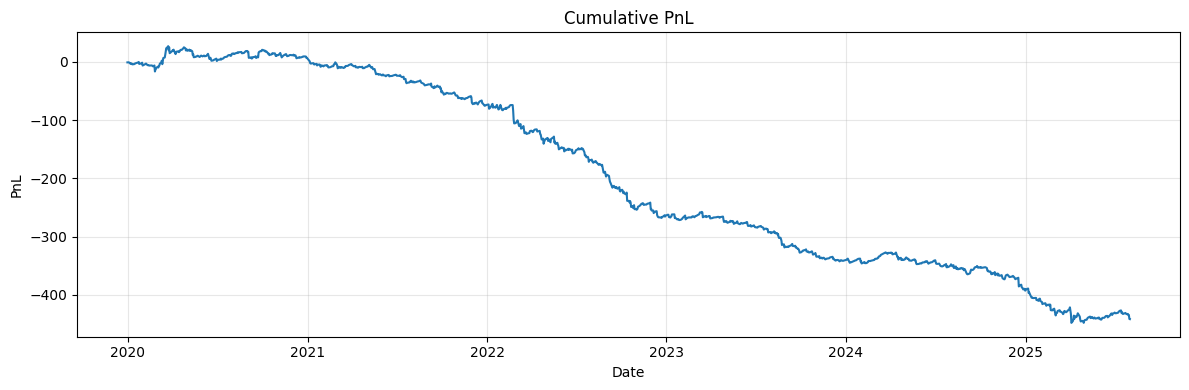

In [69]:
year = 2025

test = backtest_df.loc[pd.to_datetime(backtest_df['Date'], errors='coerce').dt.year == year]

print("For year: " + str(year))
print("Positive returns: ")
print(" # of positive days: " + str(test[test['returns'] >0]['returns'].count()))
print(" returns of positive days: " + str(test[test['returns'] >0]['returns'].sum()))
print(" # of negative days: " + str(test[test['returns'] <0]['returns'].count()))
print(" returns of negative days: " + str(test[test['returns'] <0]['returns'].sum()))
print("NET:")
print(test['returns'].sum())

import pandas as pd
import matplotlib.pyplot as plt

# Make a clean copy and sort by Date if present

# test = backtest_df[backtest_df['returns'] <0]
df = backtest_df.copy()
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date')

r = pd.to_numeric(df['returns'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

